In [335]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans


# Introduction/Business Problem

Let's say you want to start a little pizza place in Stockholm, Sweden. But you don't have the resources to compete with the major fast food companies and you also want as little competition as possible in your local area.

Where should you go and look for a place to rent? 

In this assignment I will try to find the best place in Stockholm to start a little pizza place where there is little competition but as close as the city center as possible with the assumption that the population density is higher the closer to the city center we get. 

To conlude, a pizza place near many possible customers with little competition.


# Data

To be able to do this i need all the neighborhoods in Stockholm. I found these at wikipedia page. So lets get the html from that page

In [328]:
url='https://sv.wikipedia.org/wiki/Kategori:Stadsdelar_i_Stockholm'
html=requests.get(url)
html=BeautifulSoup(html.content,'html.parser')

Then we extract all the neighborhoods with the following code:

In [205]:
html_pages=html.find('div',id='mw-pages')
html_neighborhoods=html_pages.find_all('a')
neighborhoods = []

for i in range(len(html_neighborhoods)):
    raw=html_neighborhoods[i].getText()
    hood=re.sub("[\(\[].*?[\)\]]", "", raw)
    neighborhoods.append(hood)
    
neighborhoods

['Abrahamsberg',
 'Akalla',
 'Alvik, Stockholm',
 'Aspudden',
 'Bagarmossen',
 'Bandhagen',
 'Beckomberga',
 'Björkhagen',
 'Blackeberg',
 'Bredäng',
 'Bromma Kyrka ',
 'Bromsten',
 'Bällsta',
 'Djurgården',
 'Eneby, Stockholm',
 'Enskede gård ',
 'Enskededalen',
 'Enskedefältet',
 'Fagersjö',
 'Farsta',
 'Farsta strand',
 'Farstanäset',
 'Flaten, Stockholm',
 'Flysta',
 'Fredhäll',
 'Fruängen',
 'Gamla Enskede',
 'Gamla stan',
 'Grimsta, Stockholm',
 'Gröndal',
 'Gubbängen',
 'Gärdet',
 'Hagsätra',
 'Hammarbyhöjden',
 'Hansta',
 'Herrängen',
 'Hjorthagen',
 'Husby, Stockholm',
 'Hägersten',
 'Hägerstensåsen',
 'Hässelby gård',
 'Hässelby strand',
 'Hässelby villastad',
 'Högdalen',
 'Höglandet',
 'Hökarängen',
 'Johanneshov',
 'Kista',
 'Kristineberg, Stockholm',
 'Kungsholmen ',
 'Kälvesta',
 'Kärrtorp',
 'Larsboda',
 'Liljeholmen',
 'Lilla Essingen',
 'Liseberg, Stockholm',
 'Lunda, Stockholm',
 'Långbro',
 'Långholmen',
 'Långsjö',
 'Marieberg',
 'Mariehäll',
 'Midsommarkransen',
 

In [329]:
len(neighborhoods)

117

There are 117 neighborhoods in Stockholm in this dataset.

Lets get the coordinates of Stockholm:

In [206]:

address = 'Stockholm, ST'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stockholma are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stockholma are 59.3251172, 18.0710935.


Then we get the longitudes and latitudes for each neighborgood. And make a check that they all get a match. 

In [207]:
latitude_array=[]
longitude_array=[]
for neighborhood in neighborhoods:
    address = neighborhood

    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude_array.append(location.latitude)
    longitude_array.append(location.longitude)

Now we can create a dataframe with our neighborhoods and their coordinates

In [208]:
print(len(latitude_array))
print(len(longitude_array))
print(len(neighborhoods))
df_sthlm = pd.DataFrame()
df_sthlm['neighborhood']=neighborhoods
df_sthlm['latitude']=latitude_array
df_sthlm['longitude']=longitude_array
df_sthlm

117
117
117


,neighborhood,latitude,longitude
0,Abrahamsberg,59.336468,17.953763
1,Akalla,59.414700,17.921818
2,"Alvik, Stockholm",59.333401,17.982279
3,Aspudden,59.306466,18.001373
4,Bagarmossen,59.276186,18.131340
...,...,...,...
112,Äppelviken,59.326225,17.971132
113,Örby slott,59.280940,18.029227
114,"Örby, Stockholms kommun",59.271847,18.027119
115,Östberga,59.286210,18.036771


Just to be sure we plot the first row on a map. And yes, Abrahamsberg shows where Abrahamsberg really is.
If the map is not rendered on github, please click here: https://nbviewer.jupyter.org/github/simonsjonneby/coursera-capstone/blob/master/battle-of-neighborhoods.ipynb

In [200]:
map_abrahamsberg = folium.Map(location=[latitude_array[0], longitude_array[0]], zoom_start=15)
map_abrahamsberg

Then we plot all the neighborhoods on the Stockholm map

In [142]:

map_stockholm = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, neighborhood in zip(df_sthlm['latitude'], df_sthlm['longitude'], df_sthlm['neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stockholm)  
    
map_stockholm


Lets get the Foursquare data we need.

In [331]:
CLIENT_ID =  ''
CLIENT_SECRET = ''
VERSION = '20180605' # Foursquare API version

In [144]:
df_sthlm.loc[0:0]

,neighborhood,latitude,longitude
0,Abrahamsberg,59.336468,17.953763


In [146]:
neighborhood_latitude = df_sthlm.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = df_sthlm.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = df_sthlm.loc[0, 'neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Abrahamsberg are 59.3364679, 17.9537633.


Lets try to get the venues in a 700m radius of Abrahamsberg.

In [332]:
LIMIT=100
radius=700
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=&client_secret=&v=20180605&ll=59.3364679,17.9537633&radius=700&limit=100'

In [167]:
results = requests.get(url).json()
results


{'meta': {'code': 200, 'requestId': '5ed0c8e4d03993001b303fb5'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bromma',
  'headerFullLocation': 'Bromma, Stockholm',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 9,
  'suggestedBounds': {'ne': {'lat': 59.34276790630001,
    'lng': 17.96609329718361},
   'sw': {'lat': 59.33016789369999, 'lng': 17.94143330281639}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54c91980498eeaaa58e447e0',
       'name': 'Friskis & Svettis Abrahamsberg',
       'location': {'lat': 59.33778466992911,
        'lng': 17.948773505130056,
        'labeledLatLngs': [{'label': 'display',
          'lat': 59.33778466992911,
          'lng':

In [168]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

And then we have a look at the result in a dataframe. We can see Abrahamsberg has 9 venues in a 700m radius. 

In [169]:
import json
venues = results['response']['groups'][0]['items']
nearby_venues = pd.json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(20)

,name,categories,lat,lng
0,Friskis & Svettis Abrahamsberg,Gym / Fitness Center,59.337785,17.948774
1,Daisy's,Fast Food Restaurant,59.340587,17.961140
2,Pizzeria La Bella,Pizza Place,59.333929,17.947791
3,Brommagrillen,Fast Food Restaurant,59.342037,17.949059
4,Abrahamsbergs Video,Video Store,59.335757,17.952132
5,Skidsport,Sporting Goods Shop,59.337603,17.953325
6,Bonne Femme,Bakery,59.336121,17.952388
7,Texas Longhorn,Steakhouse,59.336699,17.956992
8,Bullar & Bröd,Bakery,59.337671,17.965733


We create the function to loop over all our neighborhoods to get the venues. We change the radius back to 500.

In [170]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Then we get all the venues

In [172]:
sthlm_venues = getNearbyVenues(df_sthlm['neighborhood'],df_sthlm['latitude'],df_sthlm['longitude'])

Abrahamsberg
Akalla
Alvik, Stockholm
Aspudden
Bagarmossen
Bandhagen
Beckomberga
Björkhagen
Blackeberg
Bredäng
Bromma Kyrka 
Bromsten
Bällsta
Djurgården
Eneby, Stockholm
Enskede gård 
Enskededalen
Enskedefältet
Fagersjö
Farsta
Farsta strand
Farstanäset
Flaten, Stockholm
Flysta
Fredhäll
Fruängen
Gamla Enskede
Gamla stan
Grimsta, Stockholm
Gröndal
Gubbängen
Gärdet
Hagsätra
Hammarbyhöjden
Hansta
Herrängen
Hjorthagen
Husby, Stockholm
Hägersten
Hägerstensåsen
Hässelby gård
Hässelby strand
Hässelby villastad
Högdalen
Höglandet
Hökarängen
Johanneshov
Kista
Kristineberg, Stockholm
Kungsholmen 
Kälvesta
Kärrtorp
Larsboda
Liljeholmen
Lilla Essingen
Liseberg, Stockholm
Lunda, Stockholm
Långbro
Långholmen
Långsjö
Marieberg
Mariehäll
Midsommarkransen
Mälarhöjden
Nockeby
Nockebyhov
Norra Djurgården
Norra Ängby
Norrmalm
Nälsta
Olovslund
Orhem
Reimersholme
Riddarholmen
Riksby
Rinkeby
Råcksta
Rågsved
Skarpnäcks gård 
Skeppsholmen 
Skrubba 
Skärholmen
Sköndal
Smedslätten
Solberga, Stockholm
Solhem
Stadsh

In [173]:
sthlm_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1480,"Östermalm, Stockholm",59.336723,18.085918,Apoteket Storken,59.334465,18.086587,Pharmacy
1481,"Östermalm, Stockholm",59.336723,18.085918,ICA Supermarket,59.338865,18.090834,Grocery Store
1482,"Östermalm, Stockholm",59.336723,18.085918,Magnusson Fine Wine,59.333954,18.084824,Wine Bar
1483,"Östermalm, Stockholm",59.336723,18.085918,Historiska Muséets Restaurang,59.334575,18.090425,Restaurant
1484,"Östermalm, Stockholm",59.336723,18.085918,7-Eleven,59.340310,18.087328,Convenience Store


In [174]:
print('There are {} uniques categories.'.format(len(sthlm_venues['Venue Category'].unique())))

There are 231 uniques categories.


Text(0, 0.5, 'Frequency')

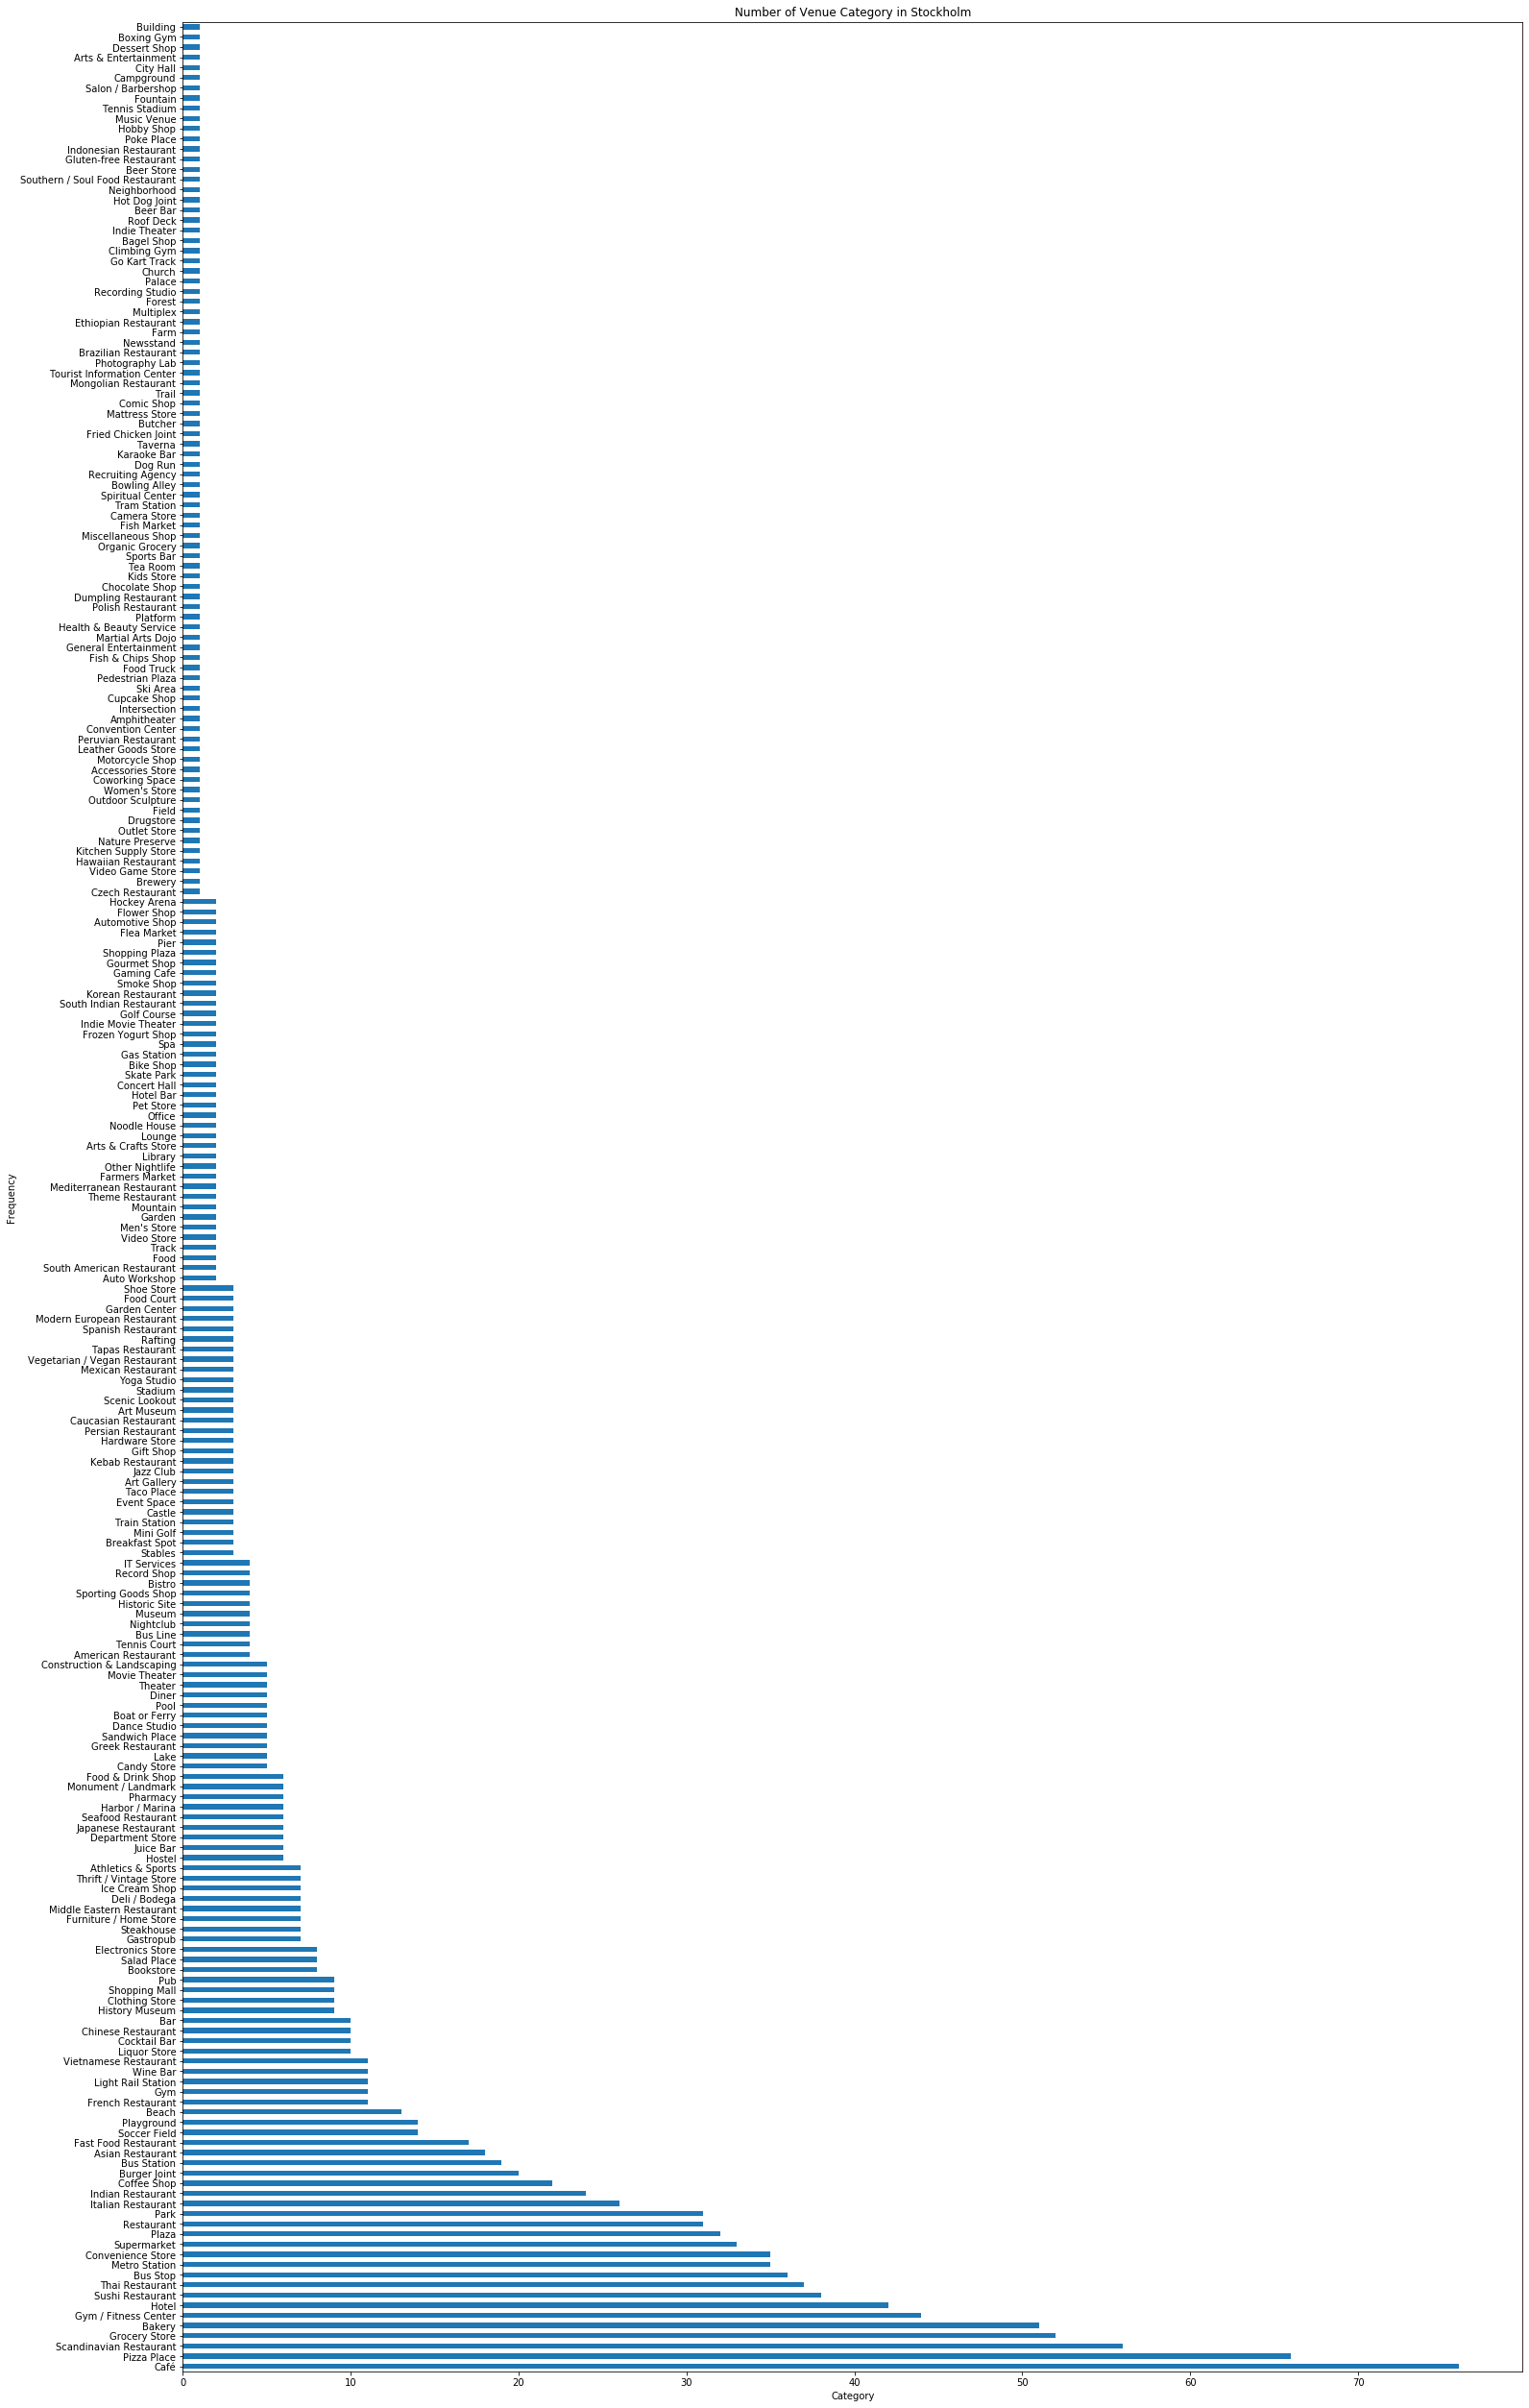

In [364]:
ax = sthlm_venues['Venue Category'].value_counts().plot(kind='barh',
                                    figsize=(25,45),
                                    title="Number of Venue Category in Stockholm"
                                    )
ax.set_xlabel("Category")
ax.set_ylabel("Frequency")


In [416]:
pizza_places=sthlm_venues[['Neighborhood','Venue Category']]
df=pizza_places.loc[pizza_places['Venue Category'] == 'Pizza Place']
df_new=df.groupby('Neighborhood').count().astype('int32')
df_new=df_new.sort_values('Venue Category')
df_new

,Venue Category
Neighborhood,
Abrahamsberg,1
Östberga,1
Kärrtorp,1
Lilla Essingen,1
Marieberg,1
Midsommarkransen,1
Nockeby,1
Sköndal,1
"Kristineberg, Stockholm",1


Text(0.5, 0, 'Frequency')

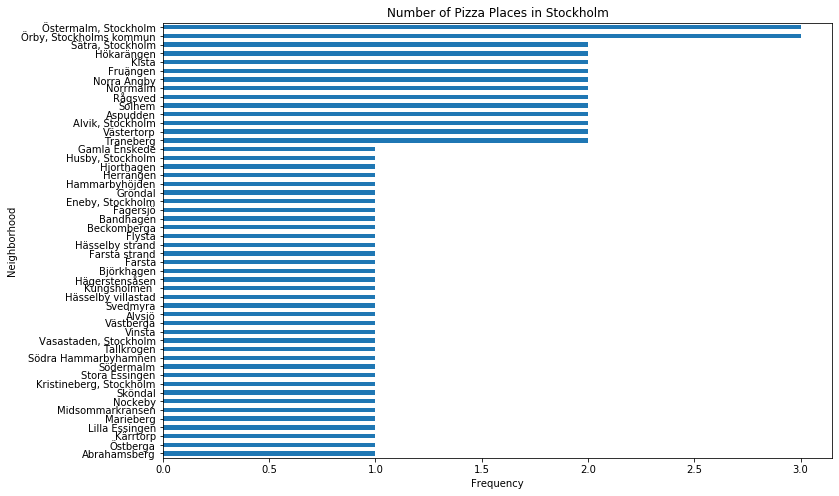

In [422]:
ax = df_new['Venue Category'].plot(kind='barh',
                                    figsize=(12,8),
                                    title="Number of Pizza Places in Stockholm"
                                    
                                    )
ax.set_ylabel("Neighborhood")
ax.set_xlabel("Frequency")


We can see that there are 231 unique categories. And now we have all the data we need to start digging in to our problem.

# Solving the problem

First we make a onehot to get all the categories into values. 

In [176]:
pd.set_option('display.max_columns', None)
sthlm_onehot = pd.get_dummies(sthlm_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sthlm_onehot['Neighborhood'] = sthlm_venues['Neighborhood'] 
sthlm_onehot

,Accessories Store,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,Bagel Shop,Bakery,Bar,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Butcher,Café,Camera Store,Campground,Candy Store,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Coworking Space,Cupcake Shop,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Drugstore,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Leather Goods Store,Library,Light Rail Station,Liquor Store,Lounge,Martial Arts Dojo,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Neighborhood,Newsstand,Nightclub,Noodle House,Office,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outlet Store,Palace,Park,Pedestrian Plaza,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pub,Rafting,Record Shop,Recording Studio,Recruiting Agency,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Ski Area,Smoke Shop,Soccer Field,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Abrahamsberg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Abrahamsberg,0,0,0,0,0,0,

Since we don't want any competition we want to count the pizza places by neighborhoods so that we don't start our place in some neighborhood with 20 pizza places.

In [196]:
df_pizza=pd.DataFrame(sthlm_onehot.groupby('Neighborhood')['Pizza Place'].sum())
df_pizza=df_pizza.reset_index()
df_pizza=df_pizza.rename(columns={"Neighborhood": "neighborhood"})
df_pizza

,neighborhood,Pizza Place
0,Abrahamsberg,1
1,Akalla,0
2,"Alvik, Stockholm",2
3,Aspudden,2
4,Bagarmossen,0
...,...,...
109,Årsta,0
110,Örby slott,0
111,"Örby, Stockholms kommun",3
112,Östberga,1


In [217]:
sthlm_pizza = pd.merge(df_sthlm, df_pizza, on='neighborhood')
sthlm_pizza

,neighborhood,latitude,longitude,Pizza Place
0,Abrahamsberg,59.336468,17.953763,1
1,Akalla,59.414700,17.921818,0
2,"Alvik, Stockholm",59.333401,17.982279,2
3,Aspudden,59.306466,18.001373,2
4,Bagarmossen,59.276186,18.131340,0
...,...,...,...,...
109,Äppelviken,59.326225,17.971132,0
110,Örby slott,59.280940,18.029227,0
111,"Örby, Stockholms kommun",59.271847,18.027119,3
112,Östberga,59.286210,18.036771,1


In [365]:
# create map
#map_stockholm_pizza = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(10)
ys = [i + x + (i*x)**2 for i in range(10)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_stockholm_pizza = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, neighborhood, pizza in zip(sthlm_pizza['latitude'], sthlm_pizza['longitude'], sthlm_pizza['neighborhood'],sthlm_pizza['Pizza Place']):
    label = folium.Popup(str(neighborhood) + ' Pizza Places ' + str(pizza), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2+pizza,
        popup=label,
        color=rainbow[pizza-1],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stockholm_pizza)  
    
map_stockholm_pizza


As we can see on the map there aren't many pizza places in Stockholm which is good news. We can see that Östermalm has 3 of them so we won't go there. But even if there isn't any pizza places in some neighborhoods we are still competing with other types of restaurants and fast food places. Lets look in to how many restaurants and other food there is in Stockholm. 

In [267]:
sthlm_restaurants = sthlm_onehot.filter(regex='Restaurant')
sthlm_restaurants['neighborhood'] = sthlm_onehot['Neighborhood'] 
sthlm_restaurants=sthlm_restaurants.groupby('neighborhood').sum()
sthlm_restaurants['Restaurants Total']= sthlm_restaurants.sum(axis=1)
sthlm_restaurants=sthlm_restaurants['Restaurants Total']
sthlm_restaurants=sthlm_restaurants.reset_index()
sthlm_restaurants

/Users/simon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,neighborhood,Restaurants Total
0,Abrahamsberg,0
1,Akalla,2
2,"Alvik, Stockholm",5
3,Aspudden,5
4,Bagarmossen,2
...,...,...
109,Årsta,0
110,Örby slott,0
111,"Örby, Stockholms kommun",0
112,Östberga,0


Text(0.5, 0, 'Frequency')

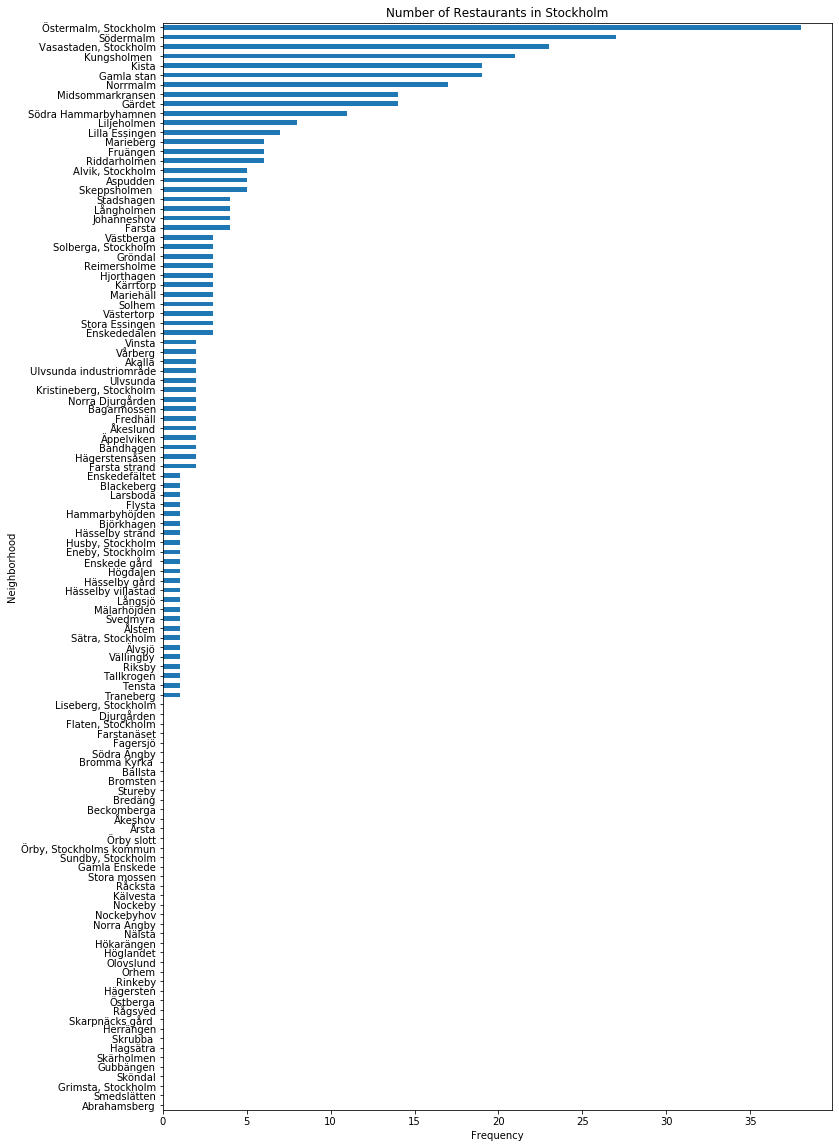

In [427]:
df_plot_restaurant=sthlm_restaurants.set_index('neighborhood').sort_values('Restaurants Total')
ax = df_plot_restaurant['Restaurants Total'].plot(kind='barh',
                                    figsize=(12,20),
                                    title="Number of Restaurants in Stockholm"
                                    
                                    )
ax.set_ylabel("Neighborhood")
ax.set_xlabel("Frequency")


In [429]:
sthlm_food = sthlm_onehot.filter(regex='Food')
sthlm_food

,Fast Food Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Southern / Soul Food Restaurant
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
1480,0,0,0,0,0,0
1481,0,0,0,0,0,0
1482,0,0,0,0,0,0
1483,0,0,0,0,0,0


In [430]:

sthlm_food.drop(columns=['Southern / Soul Food Restaurant','Fast Food Restaurant'],inplace=True)
sthlm_food['neighborhood'] = sthlm_onehot['Neighborhood'] 
sthlm_food=sthlm_food.groupby('neighborhood').sum()
sthlm_food['Food Total']= sthlm_food.sum(axis=1)
sthlm_food=sthlm_food['Food Total'].reset_index()
sthlm_food

/Users/simon/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/simon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,neighborhood,Food Total
0,Abrahamsberg,0
1,Akalla,0
2,"Alvik, Stockholm",0
3,Aspudden,0
4,Bagarmossen,0
...,...,...
109,Årsta,0
110,Örby slott,0
111,"Örby, Stockholms kommun",1
112,Östberga,0


Now we create a dataframe with all the columns that we found and also adds a total column.

In [288]:
sthlm_totals=sthlm_pizza.merge(sthlm_restaurants,on='neighborhood').merge(sthlm_food,on='neighborhood')
sthlm_totals['Totals']= sthlm_totals.iloc[:, 3:6].sum(axis=1)
sthlm_totals

,neighborhood,latitude,longitude,Pizza Place,Restaurants Total,Food Total,Totals
0,Abrahamsberg,59.336468,17.953763,1,0,0,1
1,Akalla,59.414700,17.921818,0,2,1,3
2,"Alvik, Stockholm",59.333401,17.982279,2,5,0,7
3,Aspudden,59.306466,18.001373,2,5,0,7
4,Bagarmossen,59.276186,18.131340,0,2,0,2
...,...,...,...,...,...,...,...
109,Äppelviken,59.326225,17.971132,0,2,0,2
110,Örby slott,59.280940,18.029227,0,0,0,0
111,"Örby, Stockholms kommun",59.271847,18.027119,3,0,1,4
112,Östberga,59.286210,18.036771,1,0,0,1


Then we plot Restaurants and Food places on two different maps as we did with pizza places. We find that there is a lot of restaurants in the centre of Stockholm. And a few food places. 

In [282]:
# create map
#map_stockholm_pizza = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(60)
ys = [i + x + (i*x)**2 for i in range(60)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_stockholm_restaurants = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, neighborhood, pizza in zip(sthlm_totals['latitude'], sthlm_totals['longitude'], sthlm_totals['neighborhood'],sthlm_totals['Restaurants Total']):
    label = folium.Popup(str(neighborhood) + ' Restaurants ' + str(pizza), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2+pizza,
        popup=label,
        color=rainbow[pizza-1],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stockholm_restaurants)  
    
map_stockholm_restaurants

In [292]:
# create map
#map_stockholm_pizza = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(60)
ys = [i + x + (i*x)**2 for i in range(60)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_stockholm_food = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, neighborhood, pizza in zip(sthlm_totals['latitude'], sthlm_totals['longitude'], sthlm_totals['neighborhood'],sthlm_totals['Food Total']):
    label = folium.Popup(str(neighborhood) + ' Food ' + str(pizza), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2+pizza,
        popup=label,
        color=rainbow[pizza-1],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stockholm_food)  
    
map_stockholm_food

Then we plot the totals column. 

In [291]:
# create map
#map_stockholm_pizza = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(60)
ys = [i + x + (i*x)**2 for i in range(60)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_stockholm_total = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, neighborhood, pizza in zip(sthlm_totals['latitude'], sthlm_totals['longitude'], sthlm_totals['neighborhood'],sthlm_totals['Totals']):
    label = folium.Popup(str(neighborhood) + ' Totals ' + str(pizza), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2+pizza,
        popup=label,
        color=rainbow[pizza-1],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stockholm_total)  
    
map_stockholm_total

From this we can make a lot of conclusions. We can see that if we think that we only compete with pizza places we should open in the very core of the city centre. But if we don't want competition from other restaurants we have too look further out. Lets make a cluster analysis to draw more conclusions.

In [433]:
sthlm_grouped_clustering = sthlm_totals.drop(['neighborhood','latitude','longitude','Cluster Labels'], 1)
sthlm_grouped_clustering

,Pizza Place,Restaurants Total,Food Total,Totals
0,1,0,0,1
1,0,2,1,3
2,2,5,0,7
3,2,5,0,7
4,0,2,0,2
...,...,...,...,...
109,0,2,0,2
110,0,0,0,0
111,3,0,1,4
112,1,0,0,1


In [344]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(sthlm_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

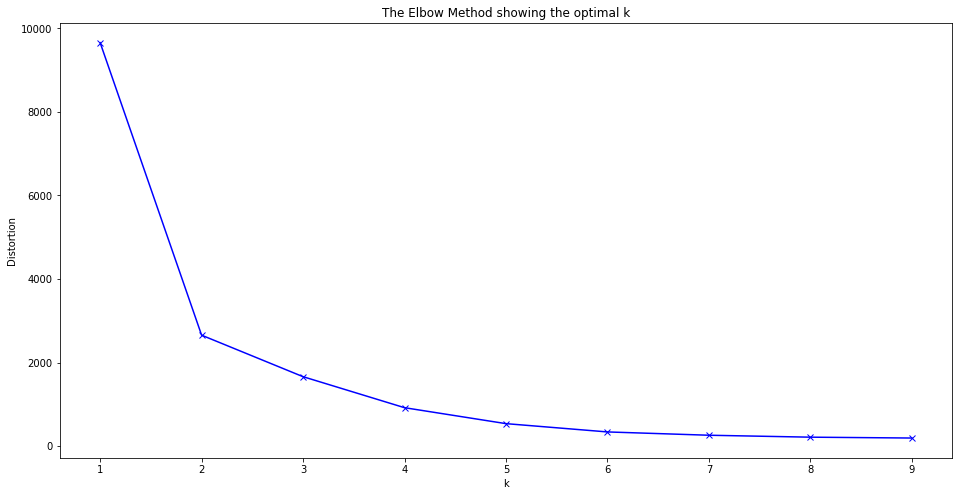

In [345]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [439]:
# set number of clusters
kclusters = 6
sthlm_totals=sthlm_totals.drop(['Cluster Labels'],1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sthlm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

sthlm_totals.insert(0, 'Cluster Labels', kmeans.labels_)
sthlm_totals

,Cluster Labels,neighborhood,latitude,longitude,Pizza Place,Restaurants Total,Food Total,Totals
0,0,Abrahamsberg,59.336468,17.953763,1,0,0,1
1,5,Akalla,59.414700,17.921818,0,2,1,3
2,2,"Alvik, Stockholm",59.333401,17.982279,2,5,0,7
3,2,Aspudden,59.306466,18.001373,2,5,0,7
4,5,Bagarmossen,59.276186,18.131340,0,2,0,2
...,...,...,...,...,...,...,...,...
109,5,Äppelviken,59.326225,17.971132,0,2,0,2
110,0,Örby slott,59.280940,18.029227,0,0,0,0
111,5,"Örby, Stockholms kommun",59.271847,18.027119,3,0,1,4
112,0,Östberga,59.286210,18.036771,1,0,0,1


In [440]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

       
folium.Circle([latitude, longitude],
                    radius=1000
                   ).add_to(map_clusters)
folium.Circle([latitude, longitude],
                    radius=2500
                   ).add_to(map_clusters)
folium.Circle([latitude, longitude],
                    radius=4000
                   ).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, pizza, restaurants, food, total in zip(sthlm_totals['latitude'], sthlm_totals['longitude'], sthlm_totals['neighborhood'], sthlm_totals['Cluster Labels'],sthlm_totals['Pizza Place'],sthlm_totals['Restaurants Total'],sthlm_totals['Food Total'],sthlm_totals['Totals']):
    label = folium.Popup(str(poi) + '| Cluster ' + str(cluster)+ ' | Pizza ' + str(pizza)+ ' | Restaurants ' + str(restaurants)+ ' | Foods ' + str(food)+ ' | Totals ' + str(total), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

By looking at this we would choose to look furher into the red and orange markers close to the city centre. 
Långholmen and Djurgården is our best options based on this analysis. Since i live in Stockholm i know that there isn't many people living on Djurgården or Långholmen and i wood rather choose another location based on the map above.
Stadshagen or Johanneshov would be great alternatives with lots of people living nearby but not many restaurants or pizza places. Therefore the next step in this analysis is to add the population density or maybe where people are moving.